In [14]:
# -*- coding: utf-8 -*-

# https://medium.datadriveninvestor.com/build-your-own-stock-portfolio-optimizer-web-app-with-streamlit-be8654ef8c65
# streamlit run app.py

In [2]:
import streamlit as st
import yfinance as yf
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from io import BytesIO
from backdata import tickers as init_tickers
from backdata import investment
from backdata import start_year, start_month, start_day

In [3]:
def plot_cum_returns(data, title):
    daily_cum_returns = 1 + data.dropna().pct_change()
    daily_cum_returns = daily_cum_returns.cumprod()*100
    fig = px.line(daily_cum_returns, title=title)
    return fig

def plot_efficient_frontier_and_max_sharpe(mu, S):
    # Optimize portfolio for max Sharpe ratio and plot it out with efficient frontier curve
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(6,4))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.legend()
    return fig

In [4]:
st.set_page_config(page_title="Bohmian's Stock Portfolio Optimizer", layout="wide")
st.header("Bohmian's Stock Portfolio Optimizer")

col1, col2 = st.columns(2)
with col1:
    start_date = st.date_input("Start Date", datetime(start_year, start_month, start_day))
with col2:
    end_date = st.date_input("End Date")  # it defaults to current date

init_tickers = init_tickers
init_tickers_string = ', '.join(init_tickers)

tickers_string = st.text_input('Enter all stock tickers to be included in portfolio separated by commas, e.g. "AAPL, '
                               'AMT, AMZN, CMG, EQIX, MSFT, UNH"', init_tickers_string).upper()
tickers_string = tickers_string.replace(" ", "")
tickers = tickers_string.split(',')

investment = int(st.text_input('Enter your investment($)', investment))

2022-09-20 20:31:23.779 
  command:

    streamlit run C:\ProgramData\Anaconda3\envs\Stock-Portfolio-Optimization\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [8]:
# Get Stock Prices using yfinance Library
if tickers[0] == '':
    stocks_df = yf.download(init_tickers, start=start_date, end=end_date)['Adj Close'].dropna(how="all")
else:
    stocks_df = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].dropna(how="all")

# stocks_df = stocks_df[stocks_df.index >= start_date]
st.dataframe(stocks_df)

[*********************100%***********************]  26 of 26 completed


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [ ]:
# Plot Individual Stock Prices
fig_price = px.line(stocks_df, title='Price of Individual Stocks')

# Plot Individual Cumulative Returns
fig_cum_returns = plot_cum_returns(stocks_df,
                                   'Cumulative Returns of Individual Stocks Starting with $' + str(investment))

# Calculatge and Plot Correlation Matrix between Stocks
corr_df = stocks_df.corr().round(4)
fig_corr = px.imshow(corr_df, text_auto=True, title='Correlation between Stocks')

In [ ]:
daily_ret = stocks_df.pct_change()  # 종목 수정 종가데이터의 일별주가상승률
annual_ret = daily_ret.mean() * 252 # 연평균 주가상승률
daily_cov = daily_ret.cov() # 일별주가상승률의 공분산행렬
annual_cov = daily_cov * 252 # 공분산행렬과 영업일 수의 곱

port_ret = [] # 포트폴리오의 일별주가상승률
port_risk = [] # 리스크
port_weights = [] # 비중
sharpe_ratio = []

In [ ]:
for _ in tqdm(range(1000000)): # 임의로 만들 포트폴리오
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights) # 임의의 가중치를 랜덤으로 부여

    returns = np.dot(weights, annual_ret) # 가중치와 연 수익률 행렬과 내적을 실시
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) # 포트폴리오의 변동성의 기댓값을 산출

    port_ret.append(returns)
    port_risk.append(risk)
    port_weights.append(weights)
    sharpe_ratio.append(returns/risk)

In [ ]:
portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe': sharpe_ratio}
for i, s in enumerate(tqdm(tickers)):
    portfolio[s] = [weight[i] for weight in port_weights]
df = pd.DataFrame(portfolio)
df = df[['Returns', 'Risk', 'Sharpe'] + [s for s in tickers]]
df

In [ ]:
min_risk = df.loc[df['Risk'] == df['Risk'].min()]  # Low Risk
max_sharpe = df.loc[df['Sharpe'] == df['Sharpe'].max()]  # Max Sharpe

C:\ProgramData\Anaconda3\envs\Stock-Portfolio-Optimization\lib\site-packages\pypfopt\risk_models.py:68: UserWarning:

The covariance matrix is non positive semidefinite. Amending eigenvalues.



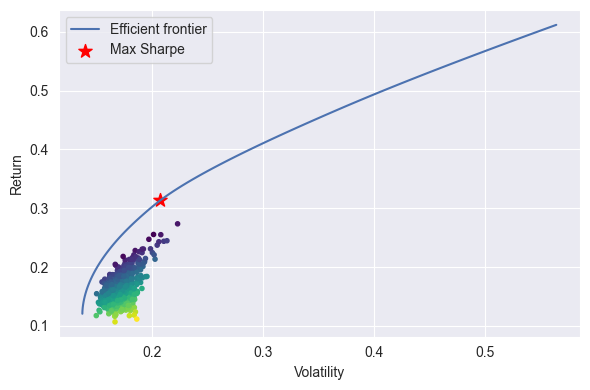

In [10]:
# Calculate expected returns and sample covariance matrix for portfolio optimization later
mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)

# Plot efficient frontier curve
fig = plot_efficient_frontier_and_max_sharpe(mu, S)
fig_efficient_frontier = BytesIO()
fig.savefig(fig_efficient_frontier, format="png")

# Get optimized weights
ef = EfficientFrontier(mu, S)
ef.max_sharpe(risk_free_rate=0.02)
weights = ef.clean_weights()
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()
weights_df = pd.DataFrame.from_dict(weights, orient='index')
weights_df.columns = ['weights']

In [11]:
# Calculate returns of portfolio with optimized weights
stocks_df['Optimized Portfolio'] = 0
for ticker, weight in weights.items():
    stocks_df['Optimized Portfolio'] += stocks_df[ticker] * weight

# Plot Cumulative Returns of Optimized Portfolio
fig_cum_returns_optimized = plot_cum_returns(
    stocks_df['Optimized Portfolio'],
    'Cumulative Returns of Optimized Portfolio Starting with $' + str(investment))

In [13]:
# Display everything on Streamlit
if tickers[0] == '':
    st.subheader("Your Portfolio Consists of {} Stocks".format(init_tickers_string))
else:
    st.subheader("Your Portfolio Consists of {} Stocks".format(tickers_string))

st.plotly_chart(fig_cum_returns_optimized)

st.subheader("Optimized Max Sharpe Portfolio Weights")
st.dataframe(weights_df)

st.subheader("Optimized Max Sharpe Portfolio Performance")
st.image(fig_efficient_frontier)

st.subheader('Expected annual return: {}%'.format((expected_annual_return * 100).round(2)))
st.subheader('Annual volatility Risk: {}%'.format((annual_volatility * 100).round(2)))
st.subheader('Sharpe Ratio: {}'.format(sharpe_ratio.round(2)))

st.plotly_chart(fig_corr)  # fig_corr is not a plotly chart
st.plotly_chart(fig_price)
st.plotly_chart(fig_cum_returns)

st.subheader('Investment: ${}'.format(investment))

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)